In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 1. Data Collection

In [2]:
stocks = {
    'RELIANCE': 'RELIANCE.NS',
    'TCS': 'TCS.NS',
    'HDFC_BANK': 'HDFCBANK.NS',
    'ITC': 'ITC.NS',
    'MARUTI': 'MARUTI.NS'
}

start_date = '2021-01-01'
end_date = '2024-10-01'  

print("Downloading stock data...")
stock_data = {}

for name, symbol in stocks.items():
    try:
        data = yf.download(symbol, start=start_date, end=end_date, progress=False)
        if len(data) > 0:
            # Extract only the Close price as a Series
            stock_data[name] = data['Close']
            print(f"✓ Downloaded {name}: {len(data)} records")
        else:
            print(f"✗ No data for {name}")
    except Exception as e:
        print(f"✗ Error downloading {name}: {str(e)}")

✓ Downloaded RELIANCE: 925 records
✓ Downloaded RELIANCE: 925 records
✓ Downloaded TCS: 925 records
✓ Downloaded TCS: 925 records
✓ Downloaded HDFC_BANK: 925 records
✓ Downloaded HDFC_BANK: 925 records
✓ Downloaded ITC: 925 records
✓ Downloaded ITC: 925 records
✓ Downloaded MARUTI: 925 records
✓ Downloaded MARUTI: 925 records


In [3]:
fixed_stock_data = {}
for name, data in stock_data.items():
    if isinstance(data, pd.DataFrame):
        # If it's a DataFrame with multiple columns, take the Close column
        if 'Close' in data.columns:
            fixed_stock_data[name] = data['Close']
        elif len(data.columns) == 1:
            # If it's a single column DataFrame, convert to Series
            fixed_stock_data[name] = data.iloc[:, 0]
        else:
            fixed_stock_data[name] = data
    else:
        fixed_stock_data[name] = data
    
    print(f"{name}: Type={type(fixed_stock_data[name])}, Length={len(fixed_stock_data[name])}")

stock_data = fixed_stock_data

RELIANCE: Type=<class 'pandas.core.series.Series'>, Length=925
TCS: Type=<class 'pandas.core.series.Series'>, Length=925
HDFC_BANK: Type=<class 'pandas.core.series.Series'>, Length=925
ITC: Type=<class 'pandas.core.series.Series'>, Length=925
MARUTI: Type=<class 'pandas.core.series.Series'>, Length=925


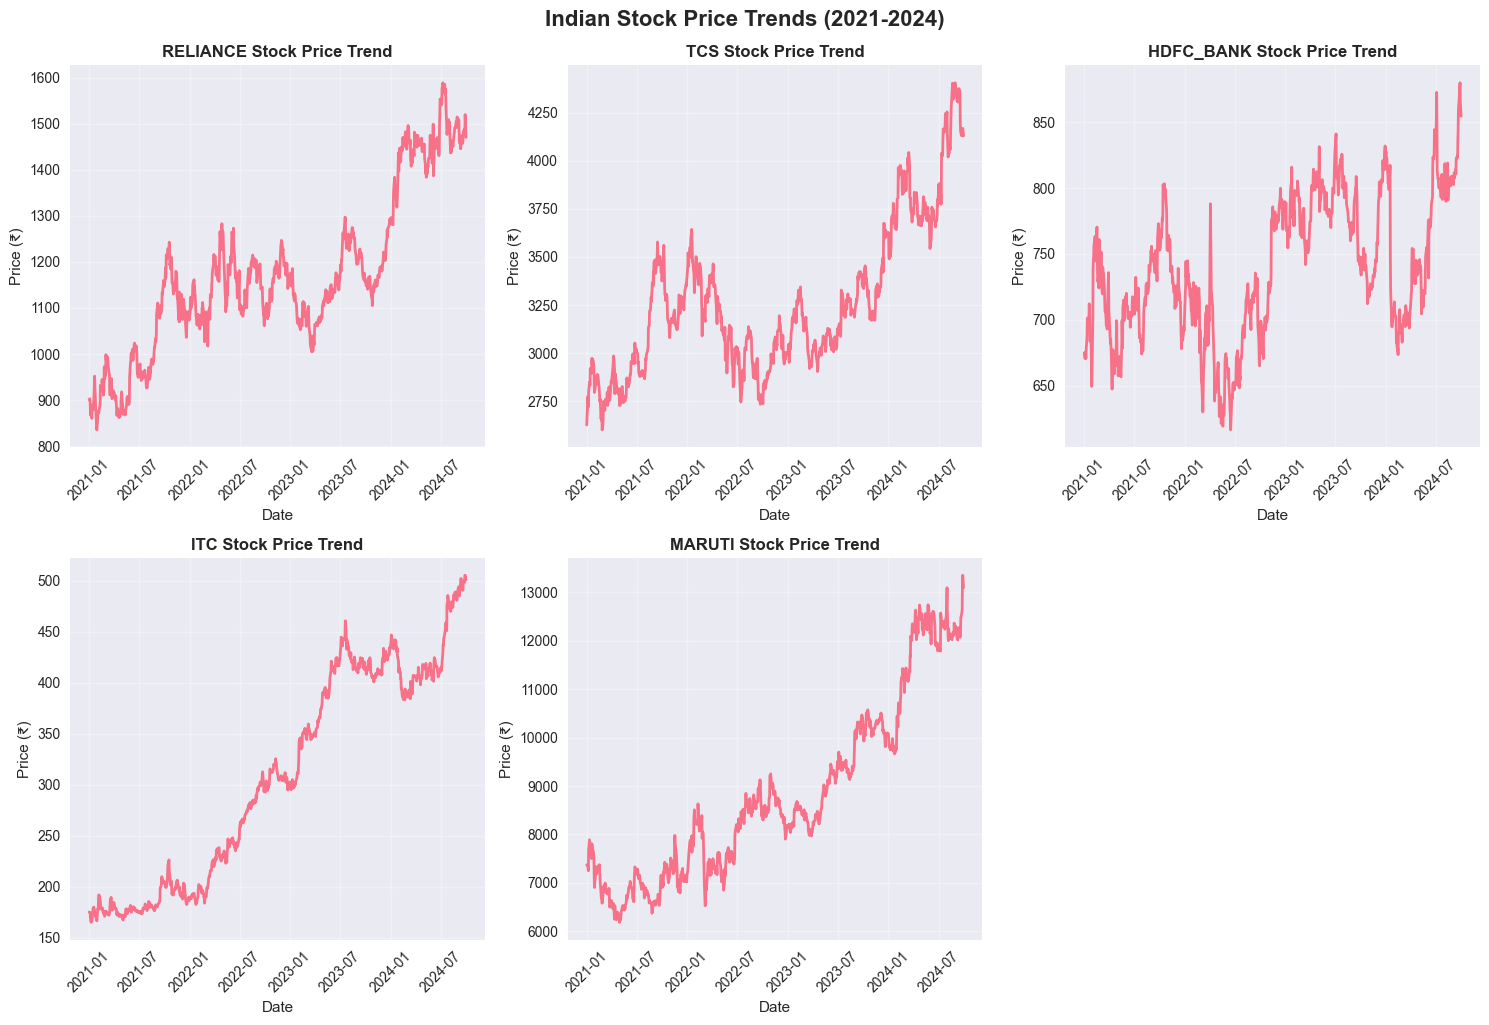

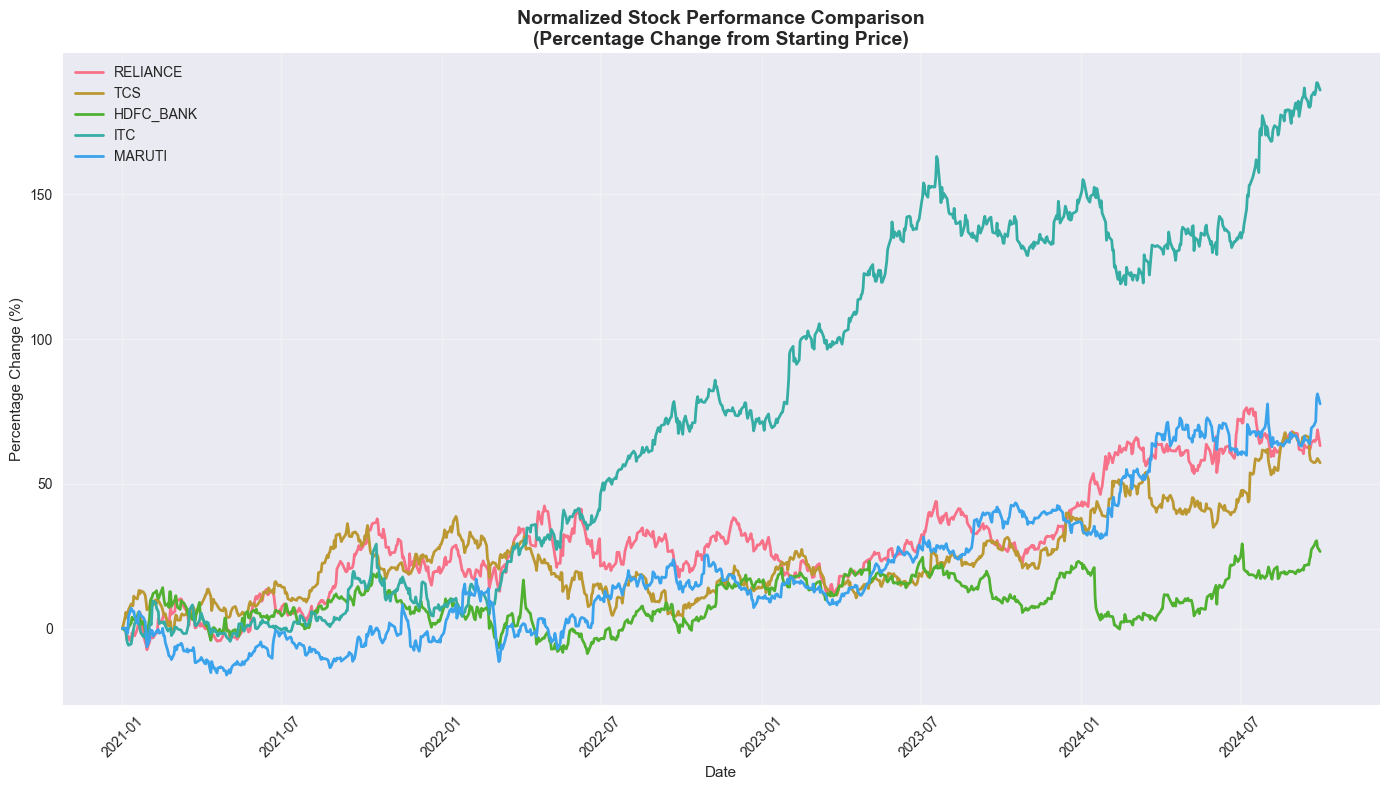

In [4]:
plt.figure(figsize=(15, 10))

for i, (name, series) in enumerate(stock_data.items(), 1):
    plt.subplot(2, 3, i)
    plt.plot(series.index, series.values, linewidth=2, label=name)
    plt.title(f'{name} Stock Price Trend', fontsize=12, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Price (₹)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.suptitle('Indian Stock Price Trends (2021-2024)', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Normalized comparison plot
plt.figure(figsize=(14, 8))
for name, series in stock_data.items():
    normalized = (series / series.iloc[0] - 1) * 100  
    plt.plot(series.index, normalized, linewidth=2, label=name)

plt.title('Normalized Stock Performance Comparison\n(Percentage Change from Starting Price)', 
         fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Stationarity Testing

In [5]:
def check_stationarity(ts, title):
    result = adfuller(ts.dropna(), autolag='AIC')
    
    print(f'ADF Test Results for {title} {"-"*50}')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("✓ Series is stationary (reject null hypothesis)")
        return True
    else:
        print("✗ Series is non-stationary (fail to reject null hypothesis)")
        return False

# Test stationarity for all stocks
stationarity_results = {}
print("Testing original series for stationarity...")
print("=" * 70)

for name, series in stock_data.items():
    is_stationary = check_stationarity(series, name)
    stationarity_results[name] = {
        'original': is_stationary,
        'series': series
    }
    print()

Testing original series for stationarity...
ADF Test Results for RELIANCE --------------------------------------------------
ADF Statistic: -1.422631
p-value: 0.571380
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
✗ Series is non-stationary (fail to reject null hypothesis)

ADF Test Results for TCS --------------------------------------------------
ADF Statistic: -1.369501
p-value: 0.596807
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
✗ Series is non-stationary (fail to reject null hypothesis)

ADF Test Results for HDFC_BANK --------------------------------------------------
ADF Statistic: -2.708098
p-value: 0.072647
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
✗ Series is non-stationary (fail to reject null hypothesis)

ADF Test Results for ITC --------------------------------------------------
ADF Statistic: 0.137802
p-value: 0.968549
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
✗ Series is non-stationary (fail to reject null hypothesis)

ADF Test R

In [6]:
# Apply differencing to make series stationary
print("All original series are non-stationary. Applying first differencing...")
print("=" * 70)

for name in stock_data.keys():
    # First differencing
    diff_series = stock_data[name].diff().dropna()
    
    # Test stationarity
    is_stationary = check_stationarity(diff_series, f"{name} (1st Difference)")
    
    stationarity_results[name]['first_diff'] = is_stationary
    stationarity_results[name]['diff_series'] = diff_series
    
    # If not try second differencing
    if not is_stationary:
        print(f"\nApplying second differencing for {name}...")
        diff2_series = diff_series.diff().dropna()
        is_stationary_2 = check_stationarity(diff2_series, f"{name} (2nd Difference)")
        stationarity_results[name]['second_diff'] = is_stationary_2
        stationarity_results[name]['diff2_series'] = diff2_series
    
    print()

All original series are non-stationary. Applying first differencing...
ADF Test Results for RELIANCE (1st Difference) --------------------------------------------------
ADF Statistic: -19.009897
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
✓ Series is stationary (reject null hypothesis)

ADF Test Results for TCS (1st Difference) --------------------------------------------------
ADF Statistic: -29.577841
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
✓ Series is stationary (reject null hypothesis)

ADF Test Results for HDFC_BANK (1st Difference) --------------------------------------------------
ADF Statistic: -22.462315
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
✓ Series is stationary (reject null hypothesis)

ADF Test Results for ITC (1st Difference) --------------------------------------------------
ADF Statistic: -15.415572
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
✓ Serie

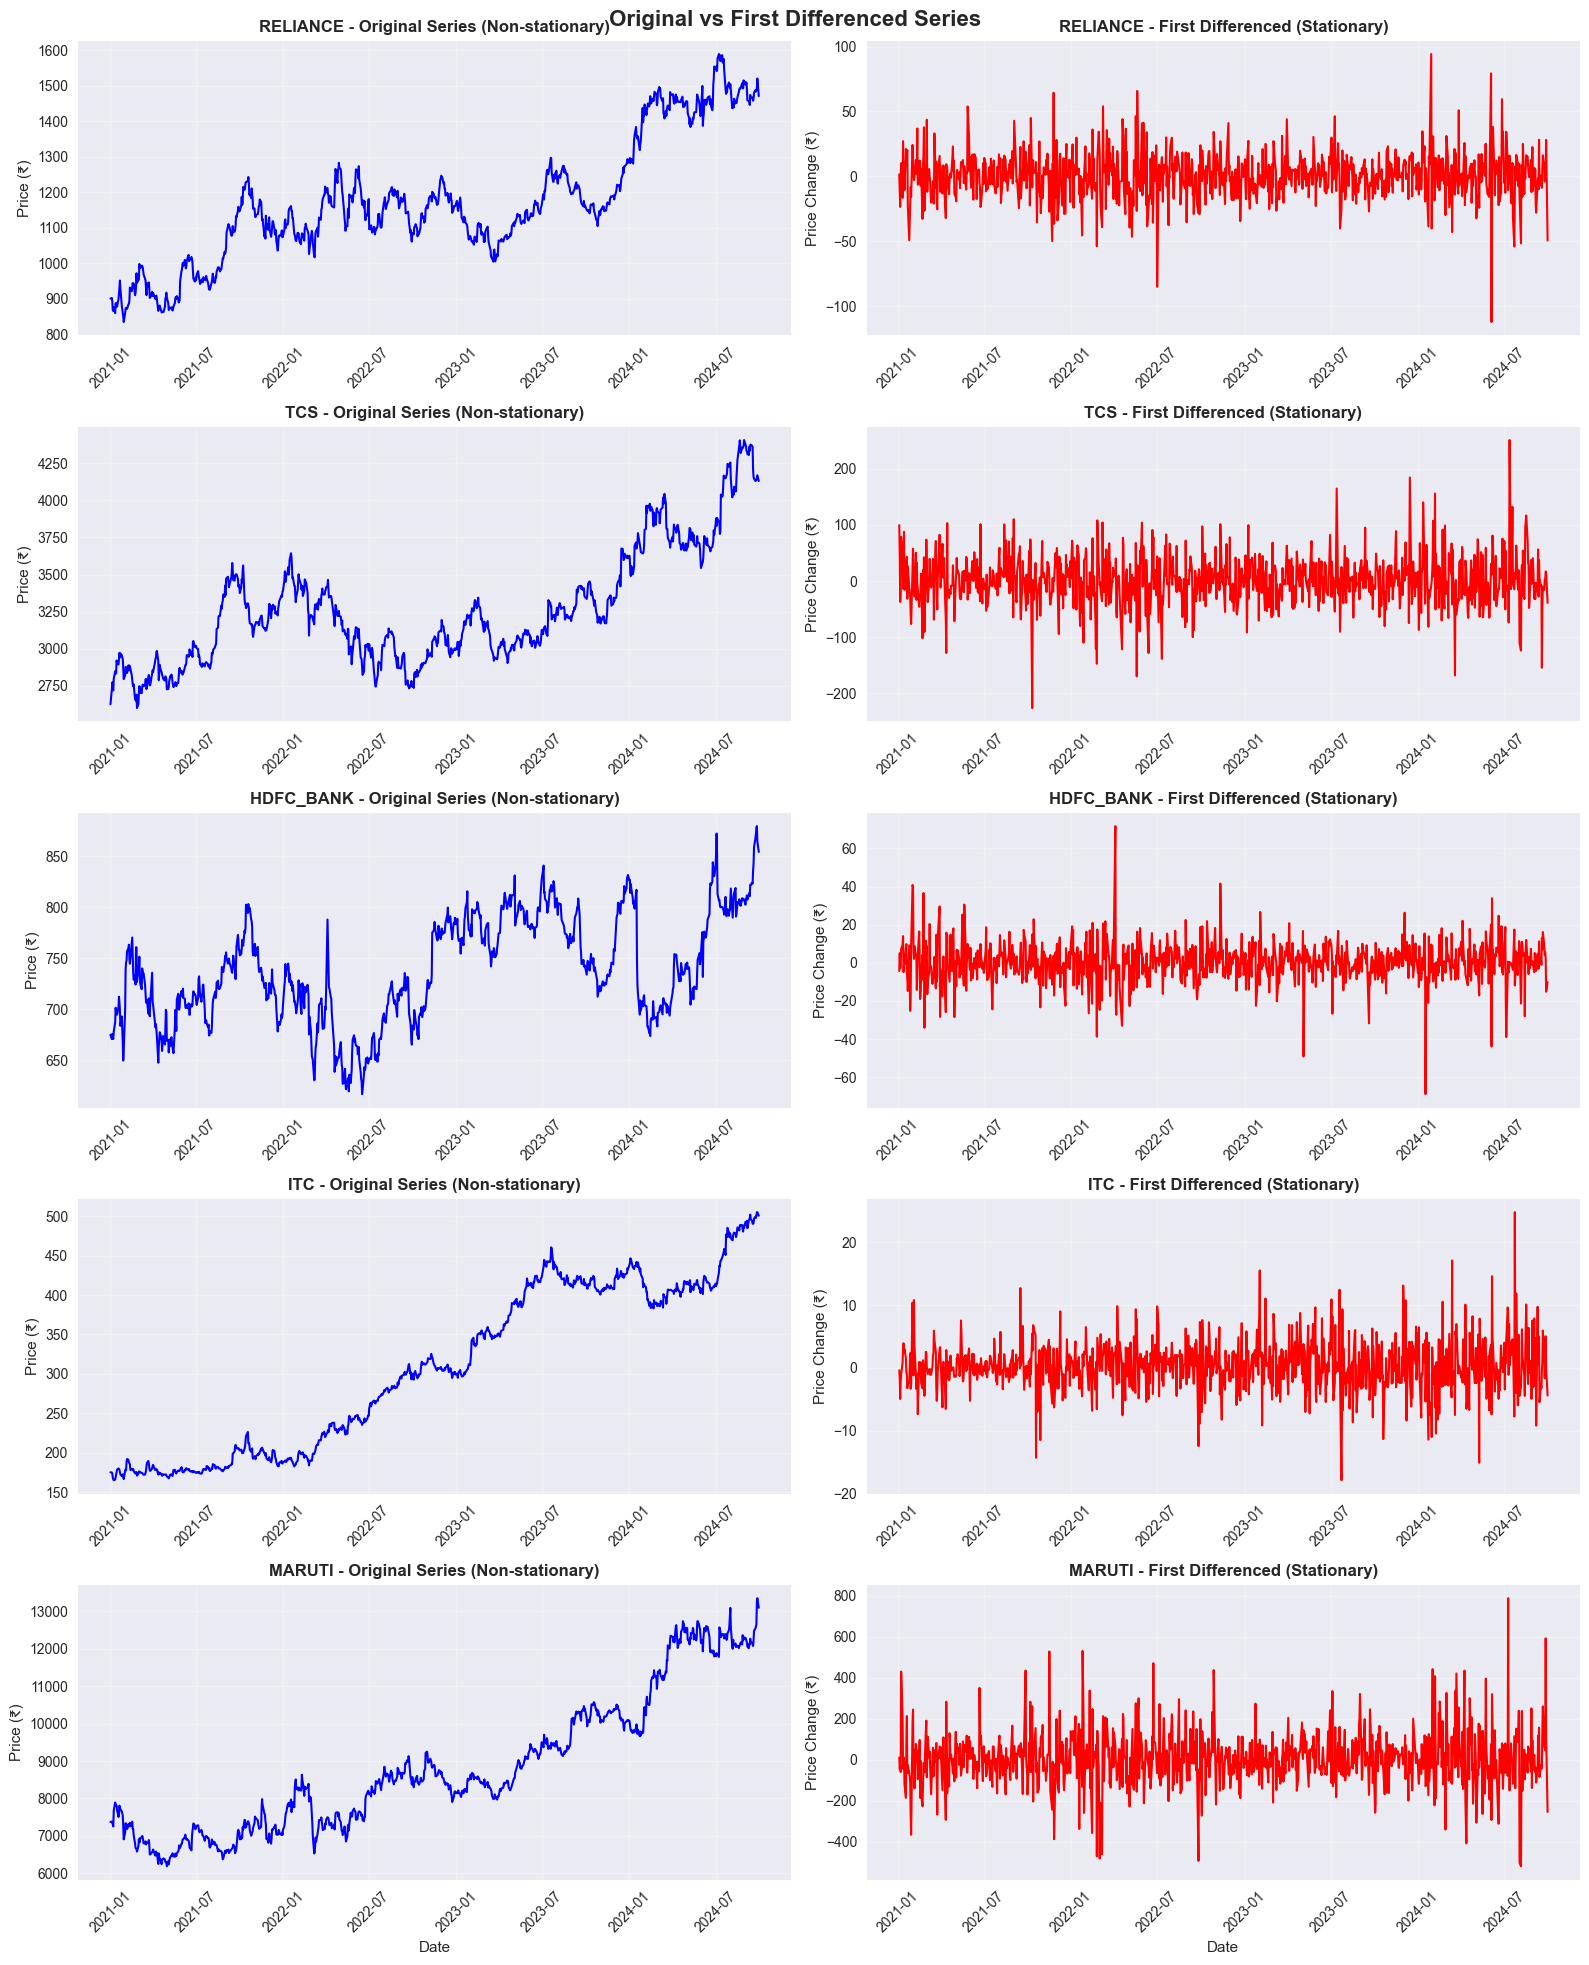


Stationarity Summary:
RELIANCE     | Original: Non-stationary | 1st Diff: Stationary
TCS          | Original: Non-stationary | 1st Diff: Stationary
HDFC_BANK    | Original: Non-stationary | 1st Diff: Stationary
ITC          | Original: Non-stationary | 1st Diff: Stationary
MARUTI       | Original: Non-stationary | 1st Diff: Stationary


In [7]:
# Visualize original vs differenced series
fig, axes = plt.subplots(len(stock_data), 2, figsize=(16, 20))
fig.suptitle('Original vs First Differenced Series', fontsize=16, fontweight='bold')

for i, (name, data) in enumerate(stationarity_results.items()):
    # Original series
    axes[i, 0].plot(data['series'].index, data['series'].values, color='blue', linewidth=1.5)
    axes[i, 0].set_title(f'{name} - Original Series (Non-stationary)', fontweight='bold')
    axes[i, 0].set_ylabel('Price (₹)')
    axes[i, 0].grid(True, alpha=0.3)
    
    # Differenced series
    diff_series = data['diff_series']
    axes[i, 1].plot(diff_series.index, diff_series.values, color='red', linewidth=1.5)
    axes[i, 1].set_title(f'{name} - First Differenced (Stationary)', fontweight='bold')
    axes[i, 1].set_ylabel('Price Change (₹)')
    axes[i, 1].grid(True, alpha=0.3)
    
    if i == len(stock_data) - 1: 
        axes[i, 0].set_xlabel('Date')
        axes[i, 1].set_xlabel('Date')
    
    for ax in axes[i]:
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary of stationarity results
print("\nStationarity Summary:")
print("=" * 50)
for name, result in stationarity_results.items():
    original_status = "Stationary" if result['original'] else "Non-stationary"
    diff_status = "Stationary" if result['first_diff'] else "Non-stationary"
    print(f"{name:12} | Original: {original_status:14} | 1st Diff: {diff_status}")

## 3. Box-Jenkins Methodology: ACF and PACF Analysis

Now we'll use the Box-Jenkins methodology to identify appropriate ARIMA parameters (p, d, q) by analyzing the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.


RELIANCE - Analysis:


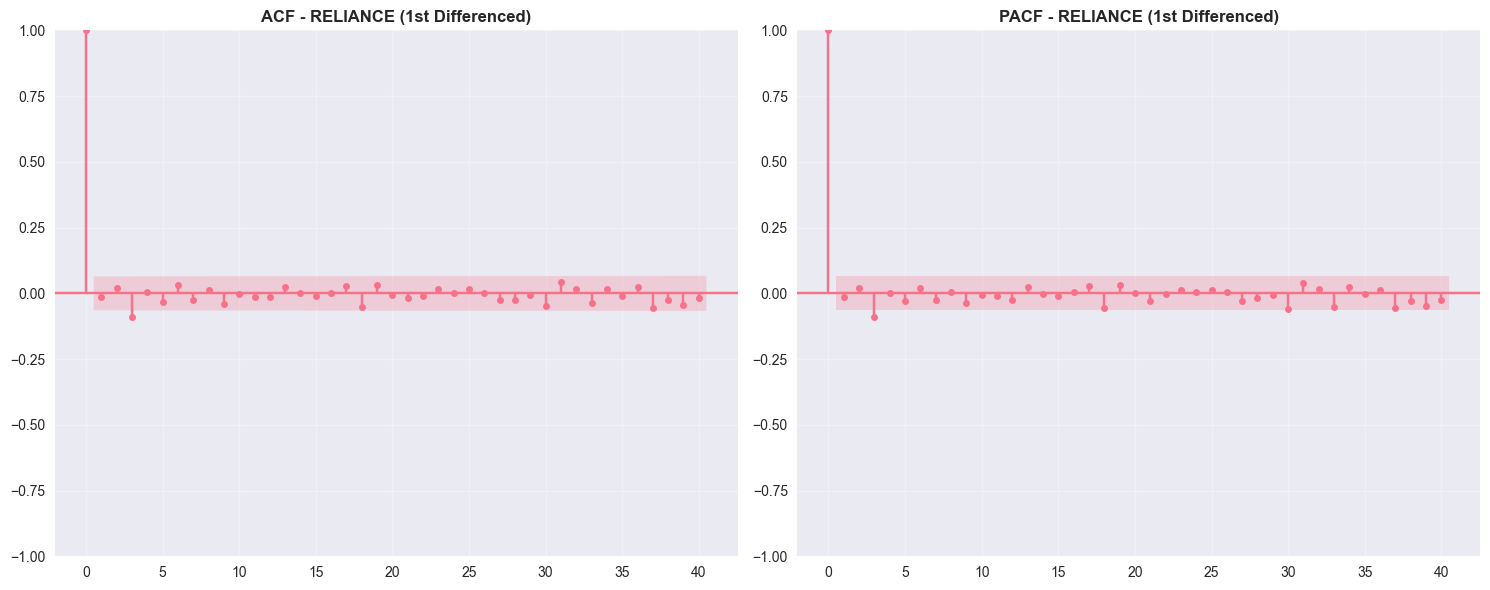


TCS - Analysis:


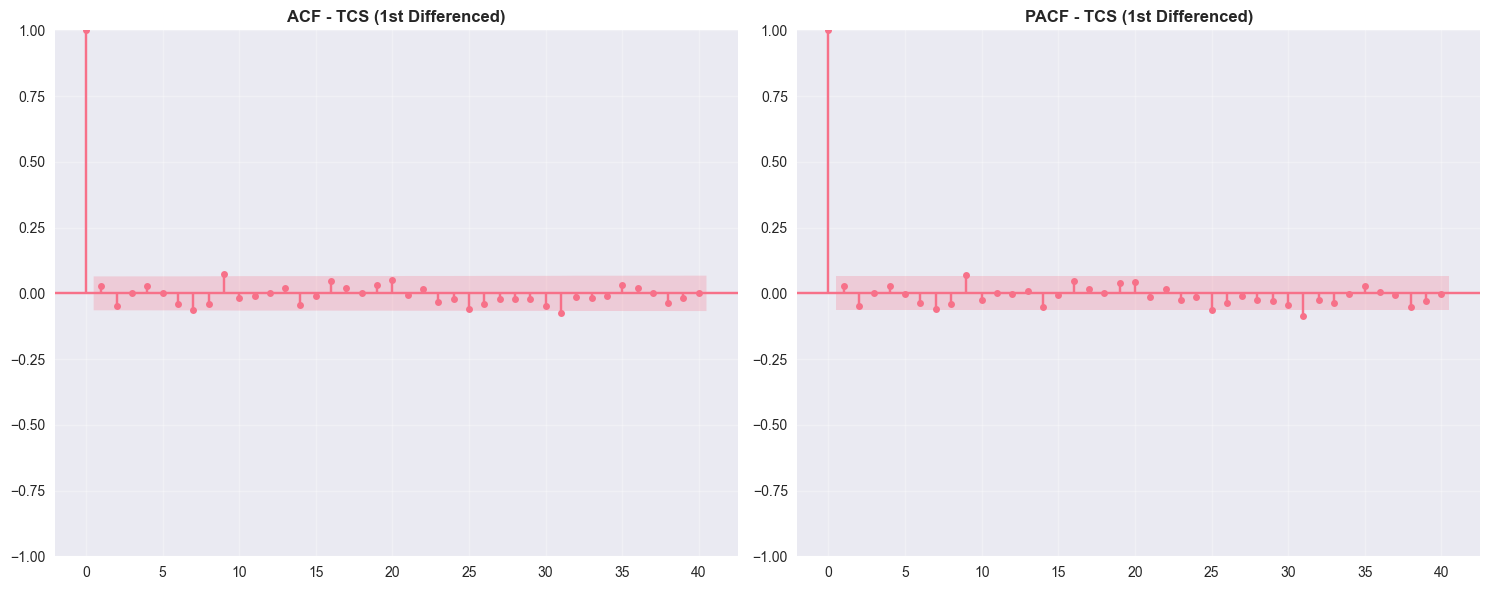


HDFC_BANK - Analysis:


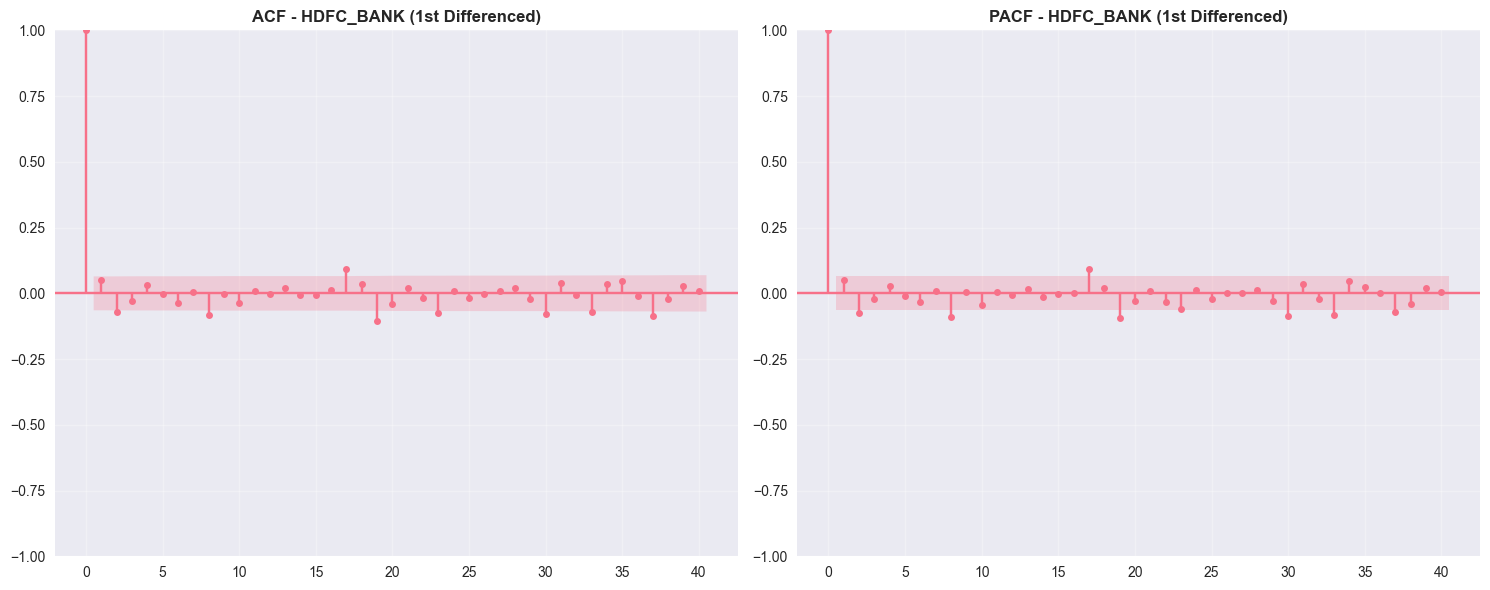


ITC - Analysis:


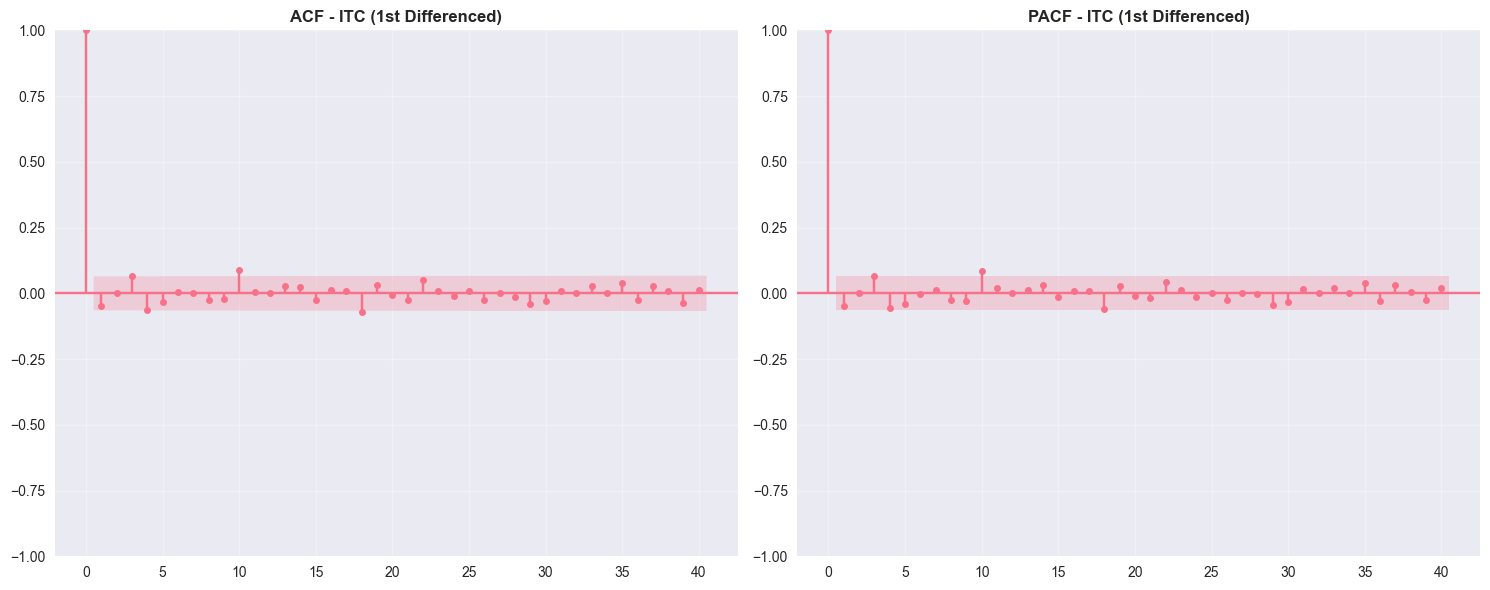


MARUTI - Analysis:


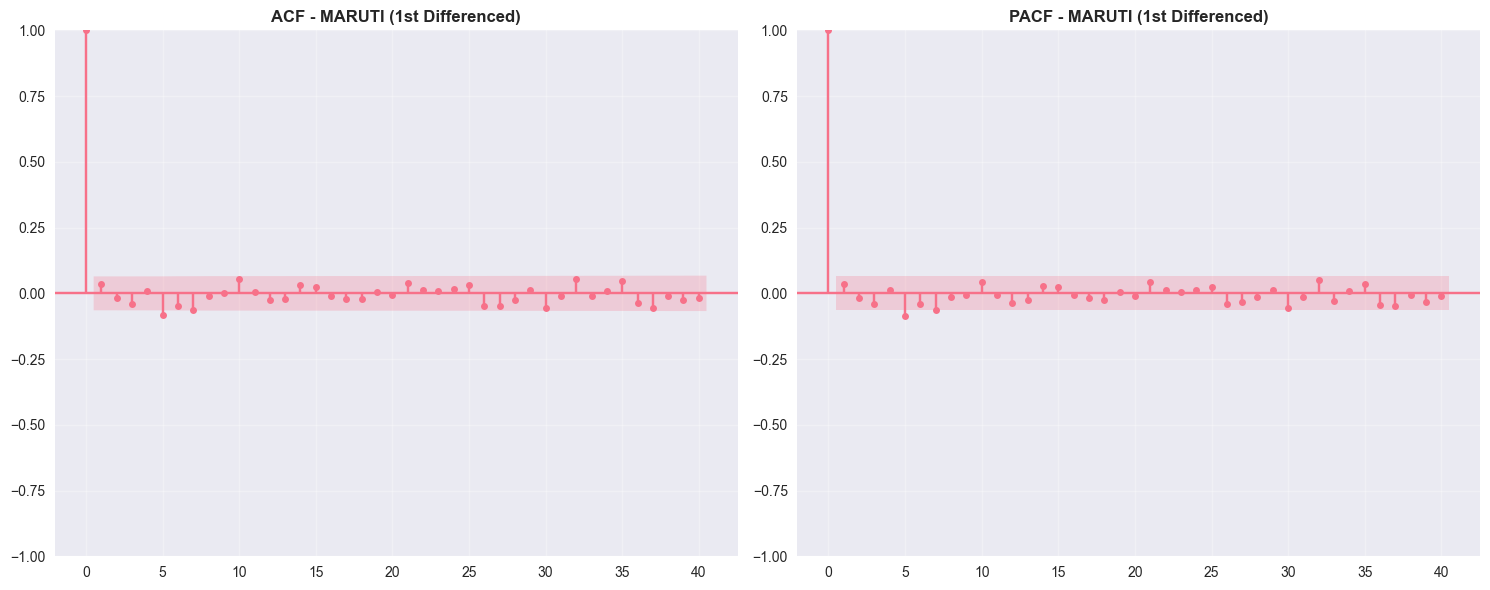

In [8]:
def plot_acf_pacf(series, title, lags=40):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # ACF plot
    plot_acf(series, ax=ax1, lags=lags, alpha=0.05)
    ax1.set_title(f'ACF - {title}', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # PACF plot
    plot_pacf(series, ax=ax2, lags=lags, alpha=0.05)
    ax2.set_title(f'PACF - {title}', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

for name, data in stationarity_results.items():
    print(f"\n{name} - Analysis:")
    plot_acf_pacf(data['diff_series'], f"{name} (1st Differenced)")

## 4. Parameter Estimation using AIC/BIC

Based on the ACF and PACF plots, we'll test different combinations of (p, q) parameters with d=1, and use AIC/BIC criteria to select the best model for each stock.

In [9]:
def find_optimal_arima(series, max_p=5, max_q=5, d=1):
    results = []
    
    print(f"Testing ARIMA parameters (max_p={max_p}, d={d}, max_q={max_q})...")
    
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                model = ARIMA(series, order=(p, d, q))
                fitted_model = model.fit()
                
                results.append({
                    'p': p, 'd': d, 'q': q,
                    'AIC': fitted_model.aic,
                    'BIC': fitted_model.bic,
                    'model': fitted_model
                })
                
            except Exception as e:
                print(f"Error with ARIMA({p},{d},{q}): {str(e)[:50]}...")
                continue
    
    results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'model'} for r in results])
    
    if len(results_df) > 0:
        # Find best models based on AIC and BIC
        best_aic_idx = results_df['AIC'].idxmin()
        best_bic_idx = results_df['BIC'].idxmin()
        
        best_aic_model = results[best_aic_idx]
        best_bic_model = results[best_bic_idx]
        
        print(f"\nBest AIC: ARIMA({best_aic_model['p']},{best_aic_model['d']},{best_aic_model['q']}) - AIC: {best_aic_model['AIC']:.2f}")
        print(f"Best BIC: ARIMA({best_bic_model['p']},{best_bic_model['d']},{best_bic_model['q']}) - BIC: {best_bic_model['BIC']:.2f}")
        
        return best_aic_model, best_bic_model, results_df
    else:
        print("No valid models found!")
        return None, None, None

# Store optimal models for each stock
optimal_models = {}

print("Finding Optimal ARIMA Parameters for Each Stock")
print("=" * 60)

for name, series in stock_data.items():
    print(f"\n{name}:")
    print("-" * 40)
    
    best_aic, best_bic, results_df = find_optimal_arima(series)
    
    if best_aic is not None:
        optimal_models[name] = {
            'best_aic': best_aic,
            'best_bic': best_bic,
            'results_df': results_df,
            'original_series': series
        }
        
        # Display top 5 models by AIC
        print("\nTop 5 Models by AIC:")
        top_aic = results_df.nsmallest(5, 'AIC')[['p', 'd', 'q', 'AIC', 'BIC']]
        print(top_aic.to_string(index=False))
    else:
        print(f"Failed to find optimal model for {name}")

Finding Optimal ARIMA Parameters for Each Stock

RELIANCE:
----------------------------------------
Testing ARIMA parameters (max_p=5, d=1, max_q=5)...

Best AIC: ARIMA(3,1,0) - AIC: 7898.42
Best BIC: ARIMA(0,1,0) - BIC: 7905.35

Top 5 Models by AIC:
 p  d  q         AIC         BIC
 3  1  0 7898.419812 7917.734660
 0  1  3 7898.926242 7918.241091
 1  1  1 7900.204524 7914.690661
 3  1  1 7900.388842 7924.532402
 4  1  0 7900.408419 7924.551979

TCS:
----------------------------------------
Testing ARIMA parameters (max_p=5, d=1, max_q=5)...

Best AIC: ARIMA(3,1,0) - AIC: 7898.42
Best BIC: ARIMA(0,1,0) - BIC: 7905.35

Top 5 Models by AIC:
 p  d  q         AIC         BIC
 3  1  0 7898.419812 7917.734660
 0  1  3 7898.926242 7918.241091
 1  1  1 7900.204524 7914.690661
 3  1  1 7900.388842 7924.532402
 4  1  0 7900.408419 7924.551979

TCS:
----------------------------------------
Testing ARIMA parameters (max_p=5, d=1, max_q=5)...

Best AIC: ARIMA(2,1,2) - AIC: 9589.43
Best BIC: ARIMA(0

In [10]:
# Create summary of optimal models
print("\nSUMMARY: Optimal ARIMA Models Selected")
print("=" * 70)
print("Stock".ljust(12) + "Best AIC Model".ljust(20) + "AIC".ljust(12) + "Best BIC Model".ljust(20) + "BIC")
print("-" * 70)

for name, models in optimal_models.items():
    aic_model = models['best_aic']
    bic_model = models['best_bic']
    
    aic_str = f"({aic_model['p']},{aic_model['d']},{aic_model['q']})"
    bic_str = f"({bic_model['p']},{bic_model['d']},{bic_model['q']})"
    
    print(f"{name.ljust(12)}{aic_str.ljust(20)}{aic_model['AIC']:<12.2f}{bic_str.ljust(20)}{bic_model['BIC']:.2f}")


SUMMARY: Optimal ARIMA Models Selected
Stock       Best AIC Model      AIC         Best BIC Model      BIC
----------------------------------------------------------------------
RELIANCE    (3,1,0)             7898.42     (0,1,0)             7905.35
TCS         (2,1,2)             9589.43     (0,1,0)             9595.31
HDFC_BANK   (3,1,3)             6949.21     (0,1,0)             6961.95
ITC         (2,1,2)             5174.31     (0,1,0)             5181.99
MARUTI      (5,1,1)             11640.82    (0,1,0)             11646.53


## 5. Diagnostic Checking: Ljung-Box Test

We'll perform the Ljung-Box test to check if the residuals of our fitted models are white noise (no autocorrelation), which is a key assumption for ARIMA models.

In [11]:
def diagnostic_check(model, name, lags=20):
    """
    Perform diagnostic checking on ARIMA model residuals
    """
    residuals = model.resid
    
    print(f"\n=== Diagnostic Check for {name} ===")
    
    # Ljung-Box test
    lb_result = acorr_ljungbox(residuals, lags=lags, return_df=True)
    
    lb_stat = lb_result['lb_stat'].iloc[-1]  # Last value (highest lag)
    lb_pvalue = lb_result['lb_pvalue'].iloc[-1]
    
    print(f"Ljung-Box Test (lag={lags}):")
    print(f"  Test Statistic: {lb_stat:.4f}")
    print(f"  P-value: {lb_pvalue:.6f}")
    
    if lb_pvalue > 0.05:
        print("  ✓ Residuals appear to be white noise (good)")
    else:
        print("  ✗ Residuals show autocorrelation (model may need improvement)")
    
    print(f"\nResidual Statistics:")
    print(f"  Mean: {residuals.mean():.6f}")
    print(f"  Std Dev: {residuals.std():.4f}")
    print(f"  Skewness: {residuals.skew():.4f}")
    print(f"  Kurtosis: {residuals.kurtosis():.4f}")
    
    return residuals, lb_stat, lb_pvalue

print("DIAGNOSTIC CHECKING RESULTS")
print("=" * 60)

diagnostic_results = {}

for name, models in optimal_models.items():
    # Use AIC-selected model for diagnostics
    best_model = models['best_aic']['model']
    model_params = models['best_aic']
    model_name = f"{name} ARIMA({model_params['p']},{model_params['d']},{model_params['q']})"
    
    residuals, lb_stat, lb_pvalue = diagnostic_check(best_model, model_name)
    
    diagnostic_results[name] = {
        'residuals': residuals,
        'lb_stat': lb_stat,
        'lb_pvalue': lb_pvalue,
        'model': best_model
    }

DIAGNOSTIC CHECKING RESULTS

=== Diagnostic Check for RELIANCE ARIMA(3,1,0) ===
Ljung-Box Test (lag=20):
  Test Statistic: 4.6185
  P-value: 0.999851
  ✓ Residuals appear to be white noise (good)

Residual Statistics:
  Mean: 1.641091
  Std Dev: 34.2868
  Skewness: 19.5514
  Kurtosis: 513.5804

=== Diagnostic Check for TCS ARIMA(2,1,2) ===
Ljung-Box Test (lag=20):
  Test Statistic: 4.7165
  P-value: 0.999824
  ✓ Residuals appear to be white noise (good)

Residual Statistics:
  Mean: 4.455526
  Std Dev: 96.4508
  Skewness: 21.7598
  Kurtosis: 591.4952

=== Diagnostic Check for HDFC_BANK ARIMA(3,1,3) ===
Ljung-Box Test (lag=20):
  Test Statistic: 3.6883
  P-value: 0.999976
  ✓ Residuals appear to be white noise (good)

Residual Statistics:
  Mean: 1.042138
  Std Dev: 24.4609
  Skewness: 22.6440
  Kurtosis: 624.6126

=== Diagnostic Check for ITC ARIMA(2,1,2) ===
Ljung-Box Test (lag=20):
  Test Statistic: 4.4934
  P-value: 0.999881
  ✓ Residuals appear to be white noise (good)

Residual St

## 6. Forecasting and Final Visualizations

In [12]:
# Generate forecasts using the corrected ARIMA approach (ARIMA already returns price levels)
forecast_days = 30
forecasts = {}

for name, models in optimal_models.items():
    model = models['best_aic']['model']
    original_series = models['original_series']
    
    # Generate forecast - ARIMA with d=1 already returns price levels!
    forecast_result = model.forecast(steps=forecast_days)
    forecast_ci = model.get_forecast(steps=forecast_days).conf_int()
    
    # Convert forecast to numpy array if needed
    if hasattr(forecast_result, 'values'):
        forecast_values = forecast_result.values
    else:
        forecast_values = np.array(forecast_result)
    
    # Create forecast dates (business days only to match stock data)
    last_date = original_series.index[-1]
    forecast_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), 
                                   periods=forecast_days)
    
    # Ensure we have the right number of dates
    if len(forecast_dates) != len(forecast_values):
        forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                     periods=len(forecast_values), freq='D')
    
    # Store forecast data
    forecasts[name] = {
        'forecast': pd.Series(forecast_values, index=forecast_dates),
        'lower_ci': pd.Series(forecast_ci.iloc[:, 0].values, index=forecast_dates),
        'upper_ci': pd.Series(forecast_ci.iloc[:, 1].values, index=forecast_dates),
        'last_price': original_series.iloc[-1],
        'model_params': (models['best_aic']['p'], models['best_aic']['d'], models['best_aic']['q'])
    }

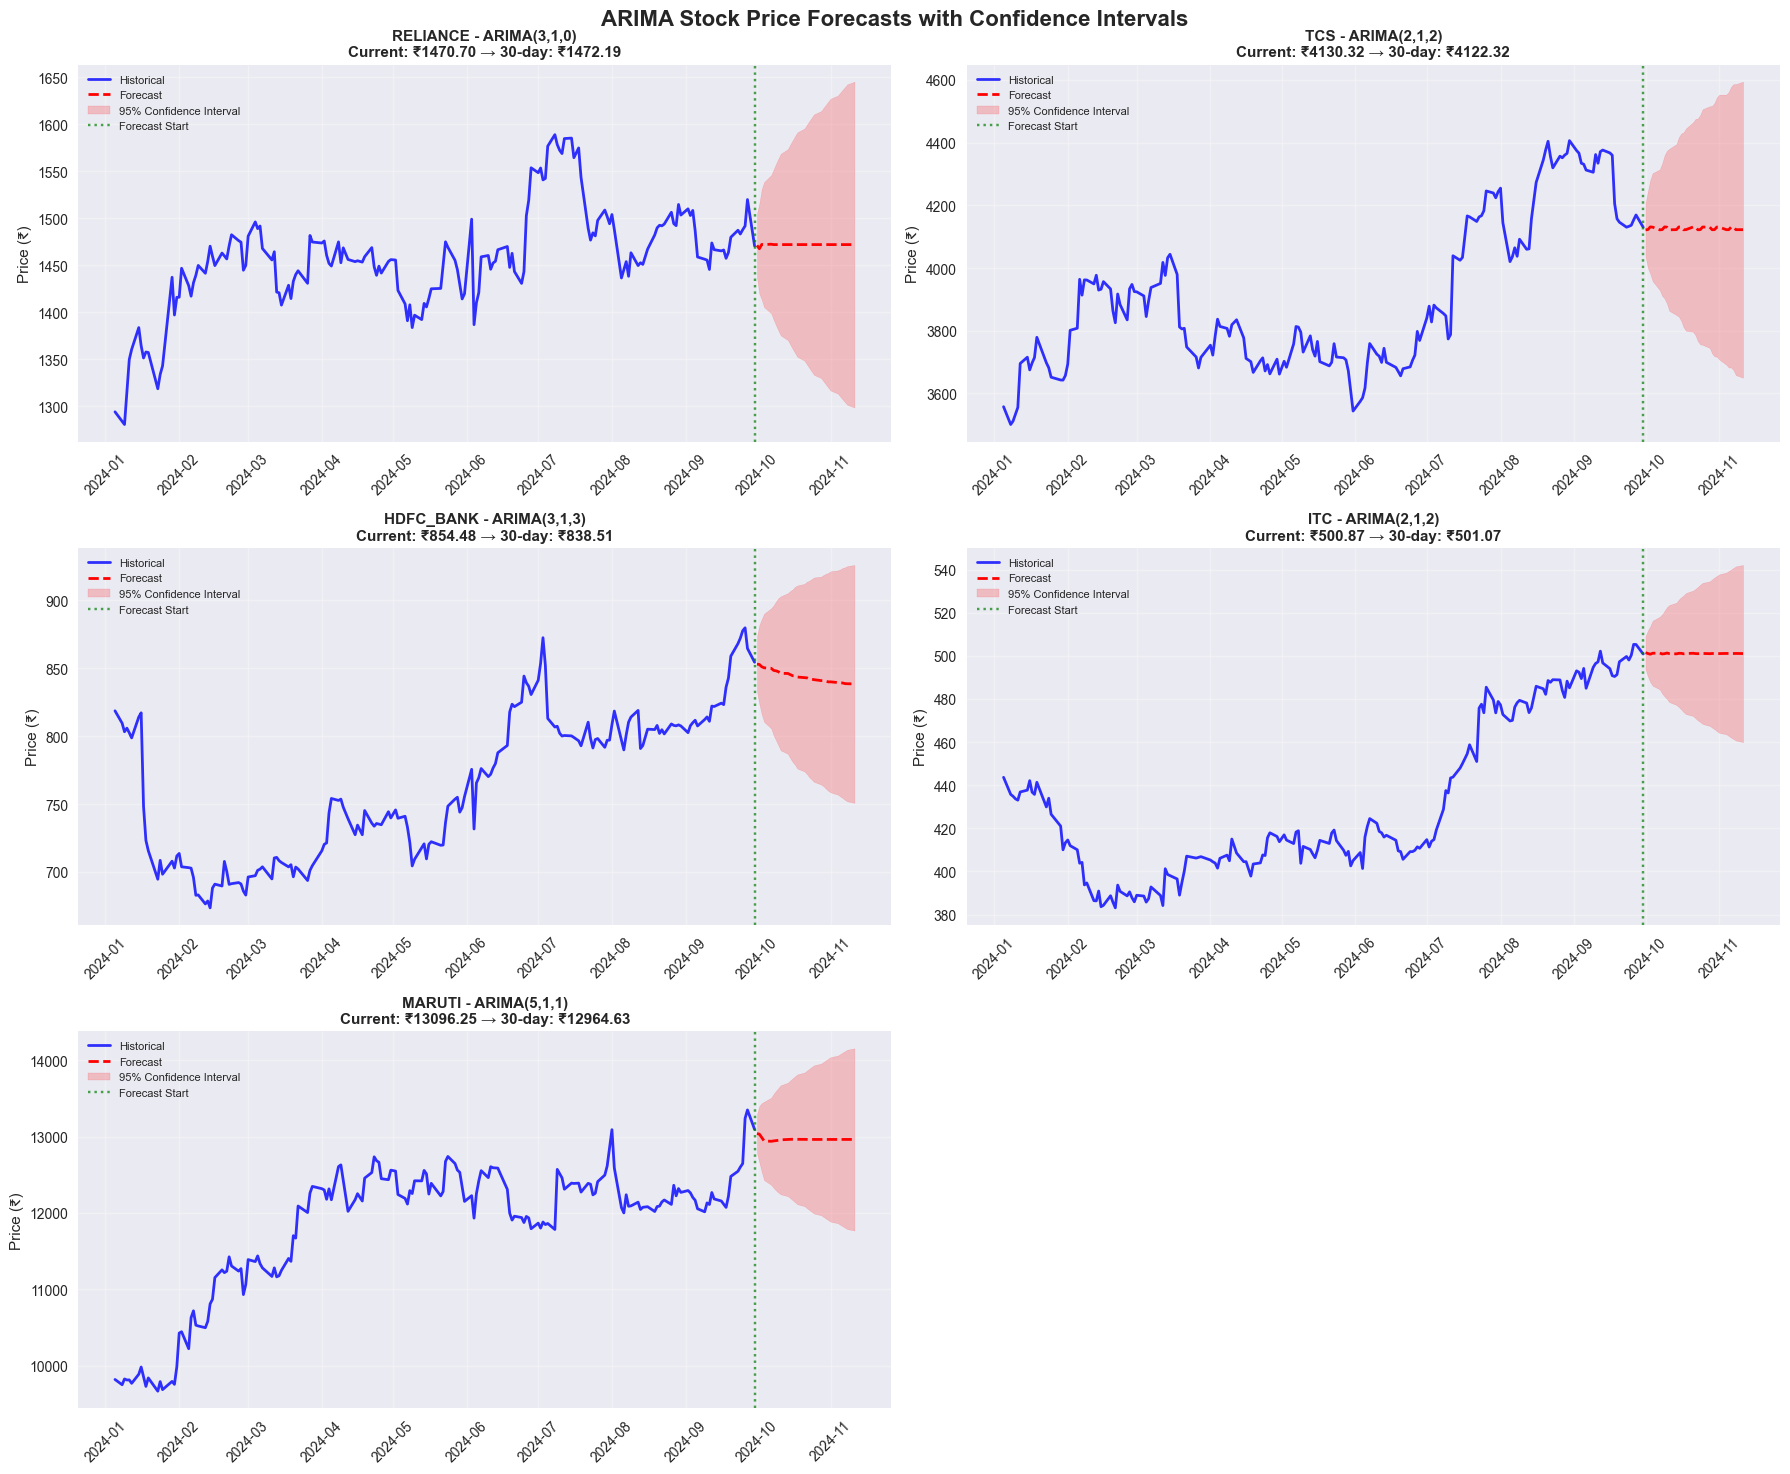

In [13]:
# Create comprehensive forecast visualizations - 2 plots per row for better clarity
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
fig.suptitle('ARIMA Stock Price Forecasts with Confidence Intervals', fontsize=16, fontweight='bold')

for i, (name, forecast_data) in enumerate(forecasts.items()):
    row = i // 2
    col = i % 2
    
    # Get historical data (last 6 months for better visualization)
    original_series = optimal_models[name]['original_series']
    recent_data = original_series.tail(180)  # Last 6 months
    
    # Plot historical prices
    axes[row, col].plot(recent_data.index, recent_data.values, 
                       color='blue', linewidth=2, label='Historical', alpha=0.8)
    
    # Plot forecast
    axes[row, col].plot(forecast_data['forecast'].index, forecast_data['forecast'].values,
                       color='red', linewidth=2, label='Forecast', linestyle='--')
    
    # Plot confidence intervals
    axes[row, col].fill_between(forecast_data['forecast'].index,
                               forecast_data['lower_ci'].values,
                               forecast_data['upper_ci'].values,
                               color='red', alpha=0.2, label='95% Confidence Interval')
    
    # Add vertical line at forecast start
    axes[row, col].axvline(x=recent_data.index[-1], color='green', 
                          linestyle=':', alpha=0.7, label='Forecast Start')
    
    # Formatting
    model_params = forecast_data['model_params']
    axes[row, col].set_title(f'{name} - ARIMA({model_params[0]},{model_params[1]},{model_params[2]})\n'
                            f'Current: ₹{forecast_data["last_price"]:.2f} → '
                            f'30-day: ₹{forecast_data["forecast"].iloc[-1]:.2f}', 
                            fontweight='bold', fontsize=11)
    axes[row, col].set_ylabel('Price (₹)')
    axes[row, col].legend(loc='upper left', fontsize=8)
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].tick_params(axis='x', rotation=45)

# Hide the empty subplot (bottom right)
if len(forecasts) == 5:
    axes[2, 1].axis('off')

plt.tight_layout()
plt.show()